In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy as sp
import sys
import os
import skimage.color as color
from skimage.transform import pyramid_laplacian
import scipy.fftpack as fftpack
import scipy.signal as signal
%matplotlib inline

Loading the video
Let load the face.mp4 video and do some basic analysis. If I load the fullfile it will occupy more than 2GB memory. When we do further processing such as pyramid generation it needs more memory. If we are working on a long time video we have to use harddisk instead of ram to store the middle result. But because face.mp4 is only 301 frames video we can use ram directly. Here in this notebook cell lets only load 60 frames for simplification, it occupies 450MB.

In [2]:
def getVideoFrames(videoFilePath, startFrameNumber=-1, endFrameNumber=-1):
    """
    Loading video file between startFrameNumber and endFrameNumber.
    Each frame is converted to YIQ color space before saving to output matrix.
    
    Parameters
    ----------
    vidoFilePath: video file path
    startFrameNumber: start frame number to read. If it is -1, then start from 0
    endFrameNumber: end frame number to read. If it is -1, then set it to the total frame number

    Returns
    -------
    fps: frame rate of the video
    frames: frames matrix with the shape (frameCount, frameHeight, frameWidth, channelCount)
    """
    frames=[]
    vidcap = cv2.VideoCapture(videoFilePath)
    fps=vidcap.get(cv2.CAP_PROP_FPS)
    totalFrame=vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
    if startFrameNumber==-1:
        startFrameNumber = 0
    if endFrameNumber == -1:
        endFrameNumber = totalFrame - 1
    success,image = vidcap.read()
    count = 0
    success = True
    while success:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = color.rgb2yiq(image).astype(np.float32)
    
      if count<startFrameNumber:
        success,image = vidcap.read()
        count+=1
        continue
      elif count>=endFrameNumber:
        break
      else:        
          frames.append(image)
      success,image = vidcap.read()
      count += 1
    frames=np.array(frames)
    
    return fps, frames

In [3]:
fps, frames = getVideoFrames('./assign2/data/face.mp4', -1, -1)
print("The video framerate is %.0f fps"%fps)
print("Success read %d frames."%frames.shape[0], "We save them in a numpy array with shape:", frames.shape, ", which occupies %d bytes"%sys.getsizeof(frames))    

The video framerate is 30 fps
Success read 300 frames. We save them in a numpy array with shape: (300, 592, 528, 3) , which occupies 1125273744 bytes


In [4]:
def compareImg(leftImg, rightImg, roi, leftTitle, rightTitle):
    """
    Compare input image pair, showing full images and the ROIs
    
    Parameters
    ----------
    leftImg, rightImg: left image and right image to compare
    roi: list of [top, bottom, left, right, extend] of ROI
    leftTitle, rightTitle: figure titles

    Returns
    -------
    Filtered image, same type as input image
    """
    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.imshow(leftImg)
    plt.title(leftTitle)

    plt.subplot(2,2,2)
    plt.imshow(rightImg)
    plt.title(rightTitle)
    
    ax = plt.subplot(2, 2, 3)
    top, bottom, left, right, extend = roi
    rect = plt.Rectangle([left, top], right-left, bottom-top, edgecolor='Red', facecolor='None')
    ax.add_patch(rect)    
    plt.imshow(leftImg)
    plt.ylim(bottom+extend, top-extend)
    plt.xlim(left-extend, right+extend)
    plt.title("ROI of " + leftTitle)
    
    ax = plt.subplot(2, 2, 4)
    top, bottom, left, right, extend = roi
    rect = plt.Rectangle([left, top], right-left, bottom-top, edgecolor='Red', facecolor='None')
    ax.add_patch(rect)    
    plt.imshow(rightImg)
    plt.ylim(bottom+extend, top-extend)
    plt.xlim(left-extend, right+extend)
    plt.title("ROI of " + rightTitle)

    plt.show()

def castFloatArray(imgIn, lowLimit=-1, highLimit=1):
    """
    Cast input float array value to between [lowLimit, highLimit]
    
    Parameters
    ----------
    imgIn: input image array

    Returns
    -------
    output image, value between [lowLimit, highLimit]
    """
    imgOut=imgIn.copy()
    if imgIn.dtype==np.float32 or imgIn.dtype==np.float64:
        imgOut[imgOut>highLimit] = highLimit
        imgOut[imgOut<lowLimit] = lowLimit
    return imgOut

def normFloatArray(imgIn):
    """
    Normalize input float array value to between [0, 1]
    If the input image has multi-channels, it does the normalization
    channel by channel, independently.
    
    Parameters
    ----------
    imgIn: input image array

    Returns
    -------
    output image, value between [0, 1]
    """
    imgOut = imgIn.copy()
    if imgIn.max()==imgIn.min():
        imgOut = np.zeros(imgIn.shape)
    elif len(imgIn.shape)==2:        
        imgOut = (imgOut - imgOut.min())/(imgOut.max()-imgOut.min())
    elif len(imgIn.shape)==3:
        for c in range(3):
            imgOut[:,:,c] = (imgOut[:,:,c] - imgOut[:,:,c].min())/(imgOut[:,:,c].max()-imgOut[:,:,c].min())
    return imgOut.astype(np.float32)

def yiq2rgbUint(imgIn):
    imgOut=(255*normFloatArray(color.yiq2rgb(castFloatArray(imgIn)))).astype(np.uint8)
    return imgOut 

def yiq2bgrUint(imgIn):
    imgOut=(255*normFloatArray(color.yiq2rgb(castFloatArray(imgIn)))).astype(np.uint8)
    imgOut=cv2.cvtColor(imgOut, cv2.COLOR_RGB2BGR)
    return imgOut 

def yiq2rgbFloat(imgIn):
    imgOut=normFloatArray(color.yiq2rgb(castFloatArray(imgIn)))
    return imgOut 

def yiq2bgrFloat(imgIn):
    tmp=imgOut=normFloatArray(color.yiq2rgb(castFloatArray(imgIn)))
    imgOut=tmp.copy()
    imgOut[:,:,0] = tmp[:,:,2]
    imgOut[:,:,1] = tmp[:,:,1]
    imgOut[:,:,2] = tmp[:,:,0]
    return imgOut 


def compareFrames(frames, frameId1, frameId2, roi):
    """
    Compare two frames in input video frames.
    The frame is converted to RGB color space before display.
    
    Parameters
    ----------
    imgIn: input image array

    Returns
    -------
    output image, value between [0, 1]
    """
    frame1=frames[frameId1,:,:,:]
    frame2=frames[frameId2,:,:,:]
    frame1rgb=yiq2rgbFloat(frame1)
    frame2rgb=yiq2rgbFloat(frame2)
    compareImg(frame1rgb, frame2rgb, roi, 'Frame %d'%frameId1, 'Frame %d'%frameId2)    

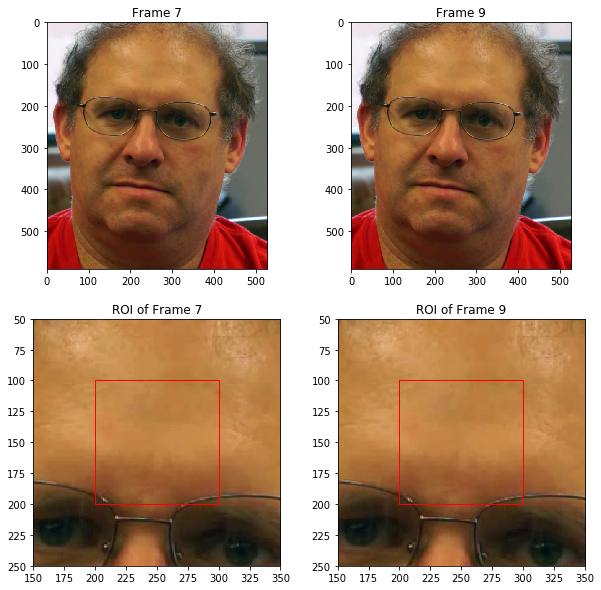

In [5]:
roi = [100, 200, 200, 300, 50]
compareFrames(frames, 7, 9, roi)

In [6]:
def draw1DTemporalSignal(frames, ypos, xpos, fps):
    frameNum, H, W, chNum = frames.shape
    tlist = [t*1000/fps for t in range(frameNum)]
    plt.figure(figsize=(20,5))
    chName=['y', 'i', 'q']
    for c in range(chNum):
        plt.subplot(1,3,c+1)
        plt.plot(tlist, frames[:,ypos, xpos, c], 'r-')
        plt.title("%s channel pixel value change for point(%d, %d)"%(chName[c], ypos, xpos))
        plt.xlabel('Time(ms)')
        plt.ylabel('Pixel Value')
    plt.show()

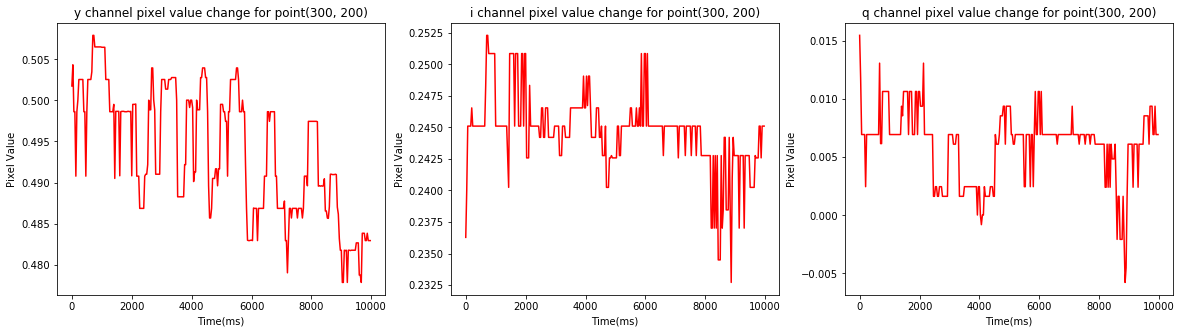

In [7]:
draw1DTemporalSignal(frames, 300, 200, fps)

In [8]:
def buildLaplacianPyramid(imgIn, maxLevel):
    """
    Build up to maxLevel laplacian pyramid for input image
    
    Parameters
    ----------
    imgIn: input image array
    maxLevel: upper limit of the pyramid levels. I also limit
           the smallest image edge in the pyramid should larger than 4 pixels
           
    Note
    ----------
    In the blur steps, it use a Gaussian filter with sigmaX=3, and sigmaY=3
    
    Returns
    -------
    Image pyramid, up to maxLevel
    """    
    currentLayer=0
    imgPyramid = []
    curSrc = imgIn.astype(np.float32)
    while(currentLayer<maxLevel-1):
        curH, curW = curSrc.shape[0:2]
        if curH < 4 or curW < 4:
            break
        currentLayer+=1 
        
        #Reduce function
        imgBlur=cv2.GaussianBlur(curSrc, ksize=(0, 0), sigmaX=3)
        imgBlurDown=cv2.resize(imgBlur, ((curW+1)//2, (curH+1)//2))
        
        #Expand function
        imgBlurUp = cv2.resize(imgBlurDown, (curW, curH))
        imgBlurUp = cv2.GaussianBlur(imgBlurUp, ksize=(0, 0), sigmaX=3)
        imgDiff=curSrc-imgBlurUp
        imgPyramid.append(imgDiff)
        curSrc = imgBlurDown

    imgPyramid.append(curSrc)
    return imgPyramid

def recreateImgsFromLapPyr(imgPyramid):
    """
    Recreate image from input Laplacian Pyramid
    
    Parameters
    ----------
    imgPyramid: input Laplacian Pyramid
    
    Note
    ----------
    In the blur step, it use a Gaussian filter with sigmaX=3, and sigmaY=3
    
    Returns
    -------
    Image recreated from inut Laplacian Pyramid
    """    
    layerNum = len(imgPyramid)
    curSrc=imgPyramid[-1].copy()
    for l in np.arange(layerNum-2, -1, -1):
        imgUp = cv2.resize(curSrc, (imgPyramid[l].shape[1], imgPyramid[l].shape[0]))
        imgBlurUp = cv2.GaussianBlur(imgUp, ksize=(0, 0), sigmaX=3)
        curSrc = imgBlurUp + imgPyramid[l]
        
    return(curSrc)    

In [9]:
def testImgPyramid(image, maxLevel, roi):
    imgPyramid = buildLaplacianPyramid(image, maxLevel)
    recreateImg = recreateImgsFromLapPyr(imgPyramid)
    recreateImg=yiq2rgbFloat(recreateImg)
    compareImg(yiq2rgbFloat(image), recreateImg, roi, "Original YIQ Frame 7", "Recreate YIQ Frame 7")

def testShowPyramid(image, maxLevel):
    rows, cols = image.shape[0:2]
    imgPyramid = buildLaplacianPyramid(image, maxLevel)
    composite_image = np.zeros((rows, cols + cols // 2, 3), dtype=np.float32)
    composite_image[:rows, :cols, :] = normFloatArray(imgPyramid[0])
    i_row = 0
    for p in imgPyramid[1:]:
        n_rows, n_cols = p.shape[:2]
        composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = normFloatArray(p)
        i_row += n_rows

    plt.figure(figsize=(15,15))
    plt.title("Laplacian Pyramid Show for Frame 7")
    plt.imshow(composite_image)
    plt.show()
  


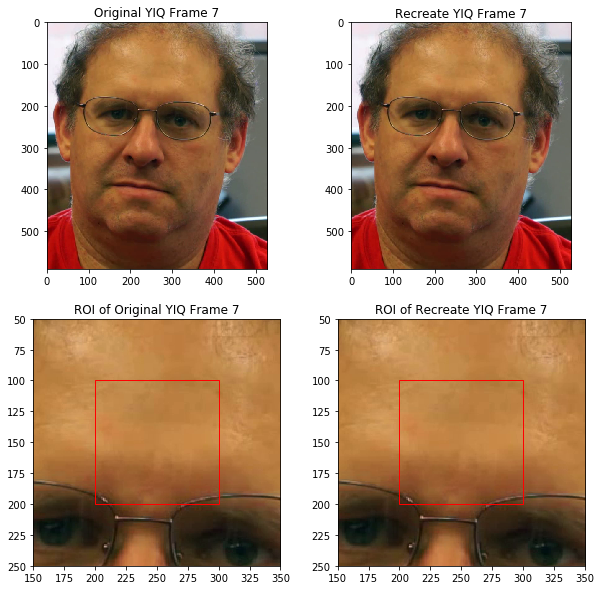

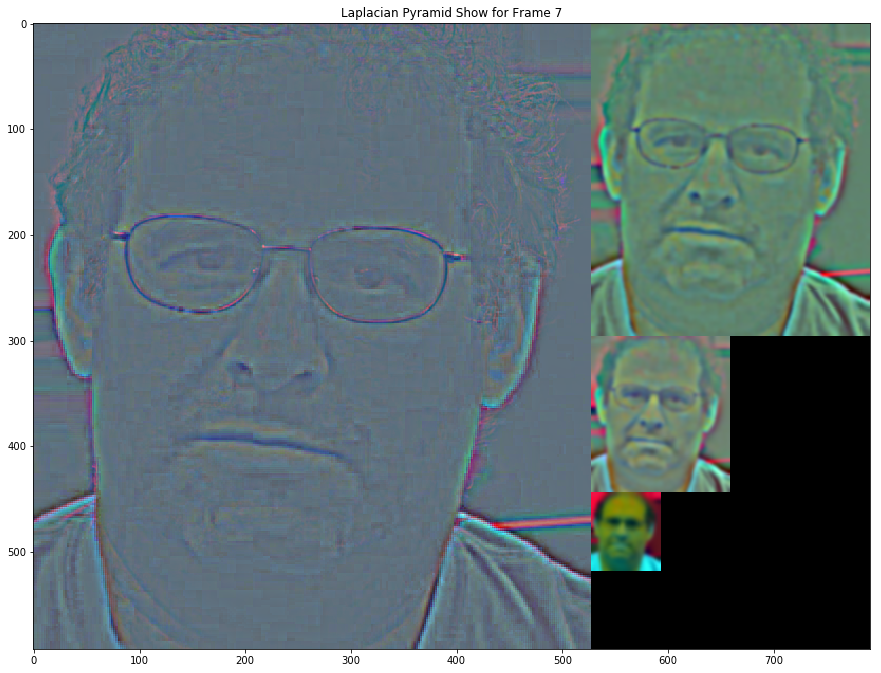

In [10]:
testFrame = frames[7]
maxLevel=4
roi = [100, 200, 200, 300, 50]
testImgPyramid(testFrame, maxLevel, roi)
testShowPyramid(testFrame, maxLevel)

In [11]:
def buildVideoLapPyr(frames, maxLevel):
    """
    Build Laplacian pyramid for input video frames
    
    Parameters
    ----------
    frames: input video frames
    maxLevel: upper limit of the Laplician pyramid layers
    
    Returns
    -------
    Laplacian pyramid for input video frames, which is a list of 
    videos that each video mapping to a layer in the laplacian pyramid.
    So each video has the shape (frameCount, videoFrameHeight, videoFrameWidth, channelCount).
    """     
    pyr0=buildLaplacianPyramid(frames[0], maxLevel)
    realMaxLevel=len(pyr0)
    
    resultList=[]
    for i in range(realMaxLevel):
        curPyr = np.zeros([len(frames)]+list(pyr0[i].shape), dtype=np.float32)
        resultList.append(curPyr)
        
    for fn in range(len(frames)):
        pyrOfFrame = buildLaplacianPyramid(frames[fn], maxLevel)
        for i in range(realMaxLevel):
            resultList[i][fn]=pyrOfFrame[i]
            
    return resultList

def recreateVideoFromLapPyr(pyrVideo):
    """
    Recreate video from input video Laplacian Pyramid
    
    Parameters
    ----------
    pyrVideo: input Laplacian Pyramid for video, returned by buildVideoLapPyr
     
    Returns
    -------
    Video recreated from inut Laplacian Pyramid
    """        
    maxLevel=len(pyrVideo)
    fNumber, H, W, chNum=pyrVideo[0].shape
    videoResult=np.zeros(pyrVideo[0].shape, dtype=np.float32)
    for fn in range(videoResult.shape[0]):
        framePyr=[pyrVideo[i][fn] for i in range(maxLevel)]
        videoResult[fn]=recreateImgsFromLapPyr(framePyr)
        
    return videoResult

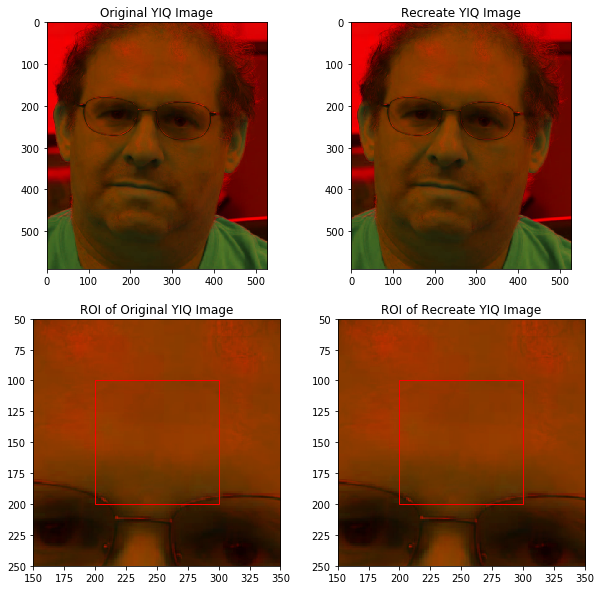

In [12]:
frameNumber=300
pyrVideo=buildVideoLapPyr(frames[0:frameNumber], maxLevel)
recreateFrames=recreateVideoFromLapPyr(pyrVideo)
compareImg(castFloatArray(frames[5], 0, 1), castFloatArray(recreateFrames[5], 0, 1), roi, "Original YIQ Image", "Recreate YIQ Image")

In [13]:
def showTemporalSignal(frames, fps, pyrVideo, layer, ypos, xpos, keyword=""):
    """
    Show temporal signal for specified layers of input video Laplacian Pyramid,
    on specified position.
    
    Parameters
    ----------
    frames: original frames
    pyrVideo: input Laplacian Pyramid for original frames, returned by buildVideoLapPyr
    layer: specified layer number to watch
    ypos, xpos: specified position to watch
     
    Returns
    -------
    None
    """      
    tlist = [t*1000/fps for t in range(pyrVideo[layer].shape[0])]
    plt.figure(figsize=(30,5))
    chName=['Y', 'I', 'Q']
    chNum = len(chName)
    ax=plt.subplot(1,4,1)
    plt.title("Frame 0 Layer %d of the %s Pyramid"%(layer, keyword))
    frame2show=normFloatArray(pyrVideo[layer][0])
    markRadius=10
    rect = plt.Rectangle([(xpos-markRadius)>>layer, (ypos-markRadius)>>layer], markRadius*2>>layer, markRadius*2>>layer, edgecolor='Red', facecolor='red')
    plt.imshow(frame2show)
    ax.add_patch(rect)
    for c in range(chNum):
        plt.subplot(1,4,c+2)
        plt.plot(tlist, pyrVideo[layer][:,ypos>>layer,xpos>>layer,c],'r-')
        plt.title("Layer %d:%s channel value for point(%d, %d)"%(layer, chName[c], ypos, xpos))
        plt.xlabel('Time(ms)')
        plt.ylabel('Pixel Value')
    plt.show()

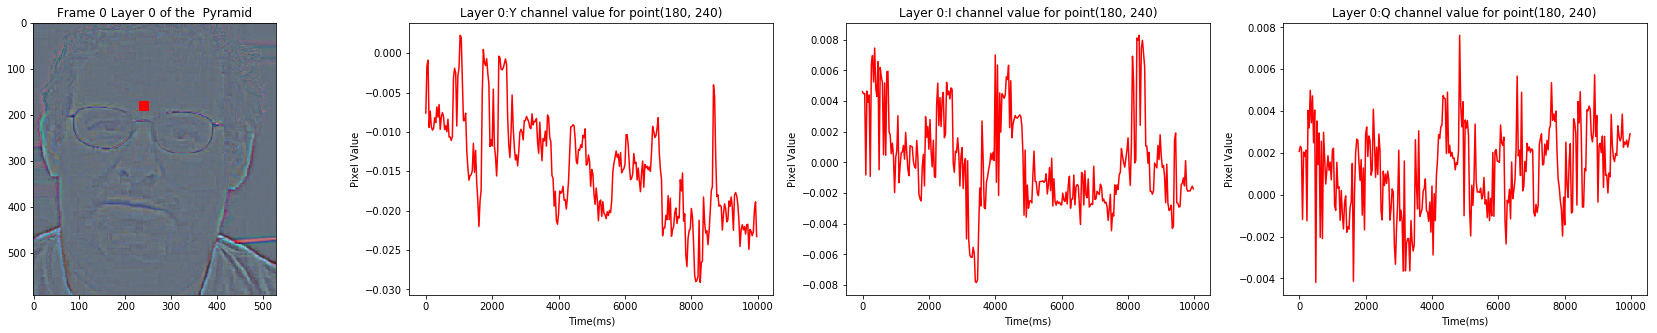

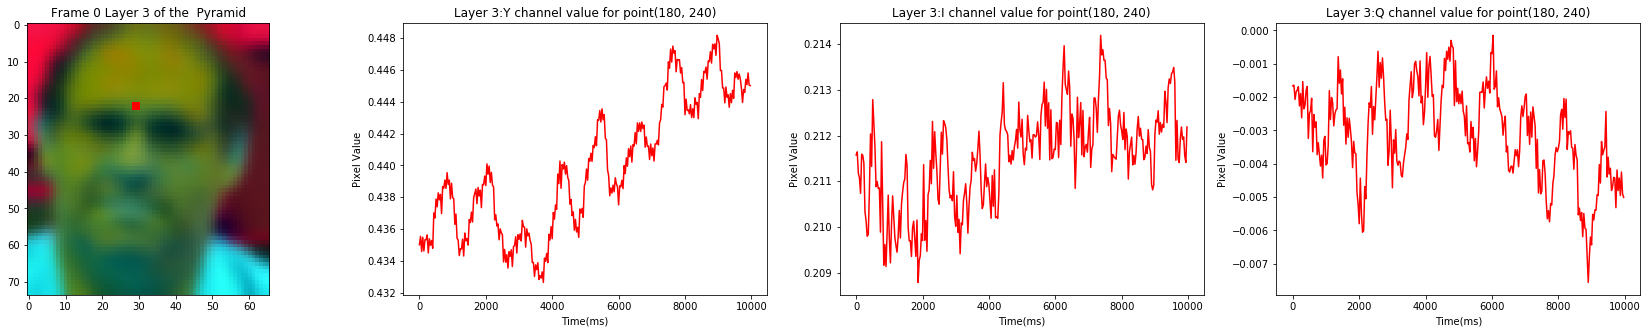

In [14]:
ypos=180
xpos=240
showTemporalSignal(frames, fps, pyrVideo, 0, ypos, xpos)
showTemporalSignal(frames, fps, pyrVideo, maxLevel-1, ypos, xpos)

In [15]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5, axis=0):
    """
    Apply butterworth bandpass filter on input data on specified axis.
    
    Parameters
    ----------
    data : data to be filered
    lowcut, hightcut: the cut frequency of the bandpass filter
    fs   : sample rate
    order: The order of the filter
    axis : The axis of the input data array along which to apply the linear filter. 
          The filter is applied to each subarray along this axis.
     
    Returns
    -------
    None
    """       
    omega = 0.5 * fs
    low = lowcut / omega
    high = highcut / omega
    b, a = signal.butter(order, [low, high], btype='band')
    y = signal.lfilter(b, a, data, axis=0)
    return y

def temporal_ideal_filter(tensor,low,high,fps,axis=0):
    """
    Apply Ideal bandpass filter on input data on specified axis.
    
    Parameters
    ----------
    tensor : data to be filered
    low, hight: the cut frequency of the bandpass filter
    fps   : sample rate
    axis : The axis of the input data array along which to apply the linear filter. 
          The filter is applied to each subarray along this axis.
     
    Returns
    -------
    None
    """      
    fft=fftpack.fft(tensor,axis=axis)
    frequencies = fftpack.fftfreq(tensor.shape[0], d=1.0 / fps)
    bound_low = (np.abs(frequencies - low)).argmin()
    bound_high = (np.abs(frequencies - high)).argmin()
    if (bound_low==bound_high) and (bound_high<len(fft)-1):
        bound_high+=1
    fft[:bound_low] = 0
    fft[bound_high:-bound_high] = 0
    fft[-bound_low:] = 0
    iff=fftpack.ifft(fft, axis=axis)
    
    return np.abs(iff)

def idealFilterForVideoPyr(videoPyr, low, high, fps, roi=None):
    """
    Apply Ideal bandpass filter on input video pyramid
    
    Parameters
    ----------
    videoPyr : video pyramid
    low, hight: the cut frequency of the bandpass filter
    fps   : sample rate
    roi : if specified, only filter roi of frames. [TODO]Not implemented yet.
     
    Returns
    -------
    None
    """     
    resultVideoPyr=[]
    for layer in range(len(videoPyr)):
        filteredPyr = temporal_ideal_filter(videoPyr[layer], low, high, fps, axis=0)
        resultVideoPyr.append(filteredPyr)
        
    return resultVideoPyr

def buttFilterForVideoPyr(videoPyr, low, high, fps, roi=None):
    """
    Apply Buttworth bandpass filter on input video pyramid
    
    Parameters
    ----------
    videoPyr : video pyramid
    low, hight: the cut frequency of the bandpass filter
    fps   : sample rate
    roi : if specified, only filter roi of frames. [TODO]Not implemented yet.
     
    Returns
    -------
    None
    """      
    resultVideoPyr=[]
    for layer in range(len(videoPyr)):
        filteredPyr = butter_bandpass_filter(videoPyr[layer], low, high, fps, order=1, axis=0)
        resultVideoPyr.append(filteredPyr)
        
    return resultVideoPyr


In [17]:
freqLow = 0.83/2
freqHigh = 1.0/2
filteredVideoPyr=idealFilterForVideoPyr(pyrVideo, freqLow, freqHigh, fps)
filteredVideo   =recreateVideoFromLapPyr(filteredVideoPyr)

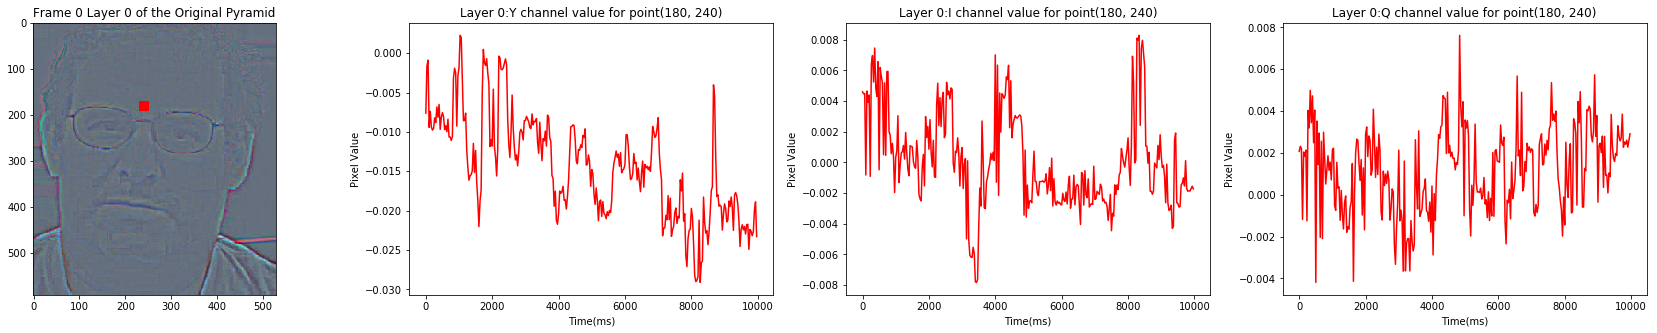

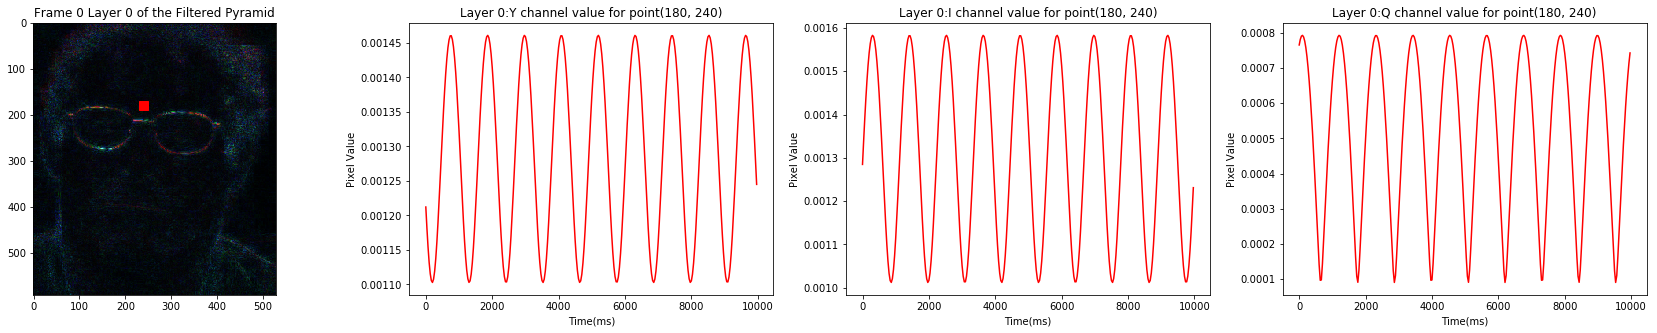

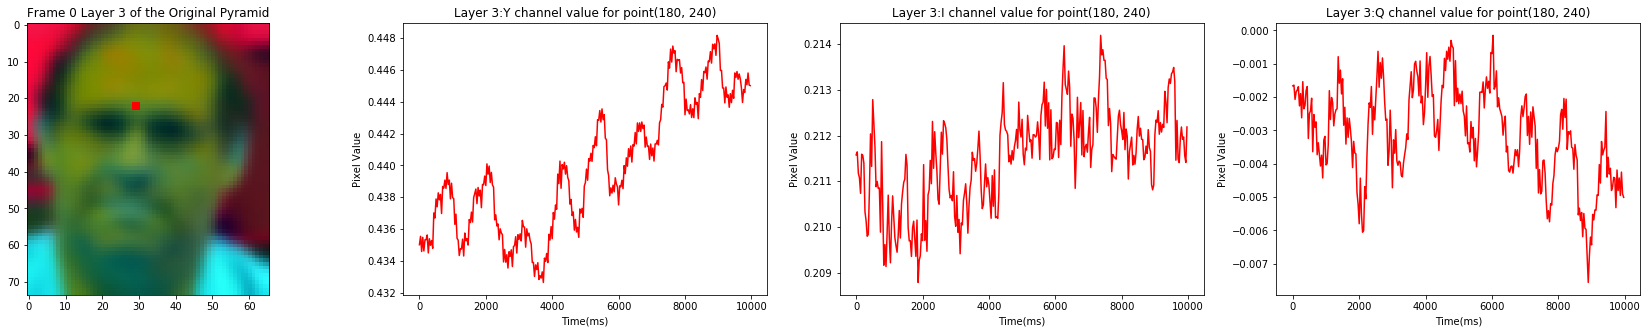

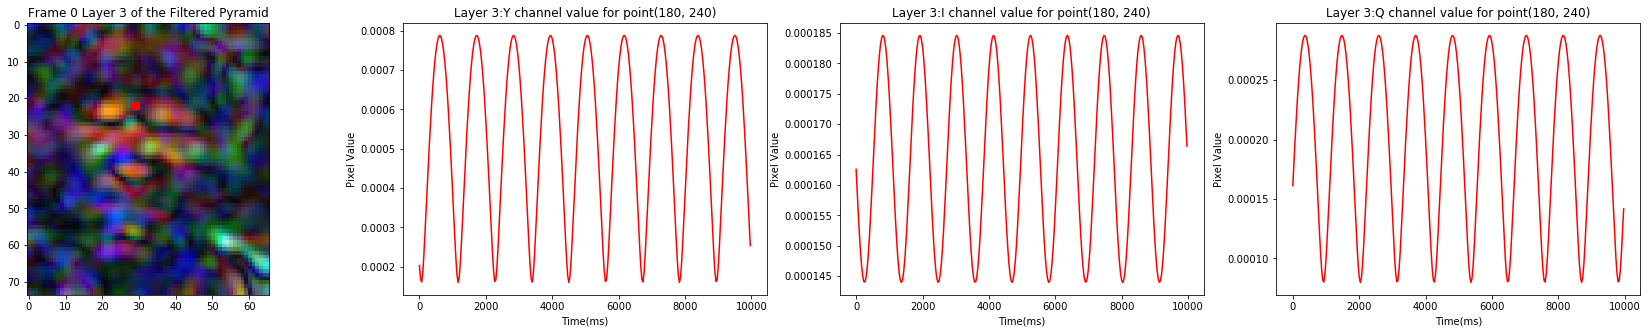

In [18]:
ypos=180
xpos=240
showTemporalSignal(frames, fps, pyrVideo, 0, ypos, xpos, "Original")
showTemporalSignal(frames, fps, filteredVideoPyr, 0, ypos, xpos, "Filtered")
showTemporalSignal(frames, fps, pyrVideo, maxLevel-1, ypos, xpos, "Original")
showTemporalSignal(frames, fps, filteredVideoPyr, maxLevel-1, ypos, xpos, "Filtered")

In [19]:
def amplifyTemporalColorSignal(originalPyr, filteredVideoPyr, alpha, chromAttenuation):
    """
    Amplify the input temporal color change signal
    
    Parameters
    ----------
    originalPyr : original video Laplacian pyramid
    filteredVideoPyr: temporal filtered video laplacian pyramid
    alpha   : amplify ratio
    chromAttenuation : for I/Q channel we can use this value for some attenuation, according to [1] 
     
    Returns
    -------
    Amplified color change signal
    """       
    amplifiedPyr=[]
    
    for layer in range(len(filteredVideoPyr)):
        tensor = originalPyr[layer].copy()
        if layer==len(filteredVideoPyr)-1:
            tensor[:,:,:,0] += filteredVideoPyr[layer][:,:,:,0] * alpha
            tensor[:,:,:,1] += filteredVideoPyr[layer][:,:,:,1] * alpha * chromAttenuation
            tensor[:,:,:,2] += filteredVideoPyr[layer][:,:,:,2] * alpha * chromAttenuation
            
        amplifiedPyr.append(tensor)
        
    return amplifiedPyr 

def amplifyTemporalMotionSignal(originalPyr, filteredVideoPyr, alpha, lambdaC, chromAttenuation):
    """
    Amplify the input temporal motion signal
    
    Parameters
    ----------
    originalPyr : original video Laplacian pyramid
    filteredVideoPyr: temporal filtered video laplacian pyramid
    alpha   : amplify ratio
    chromAttenuation : for I/Q channel we can use this value for some attenuation, according to [1] 
     
    Returns
    -------
    Amplified motion signal
    """       
    amplifiedPyr=[]
    
    delta = lambdaC/8/(1+alpha)
    frameCount, H, W, chCount= originalPyr[0].shape
    lamb = np.sqrt(H**2+W**2)/3.0

    for layer in range(len(filteredVideoPyr)):
        tensor = originalPyr[layer].copy()
        if layer==len(filteredVideoPyr)-1 or layer==0:
            currAlpha = 0
        elif currAlpha > alpha:
            currAlpha = alpha
        else:
            currAlpha = lamb/delta/8 - 1
            
        tensor[:,:,:,0] += filteredVideoPyr[layer][:,:,:,0] * currAlpha
        tensor[:,:,:,1] += filteredVideoPyr[layer][:,:,:,1] * currAlpha * chromAttenuation
        tensor[:,:,:,2] += filteredVideoPyr[layer][:,:,:,2] * currAlpha * chromAttenuation
            
        amplifiedPyr.append(tensor)
        lamb /= 2
        
    return amplifiedPyr 


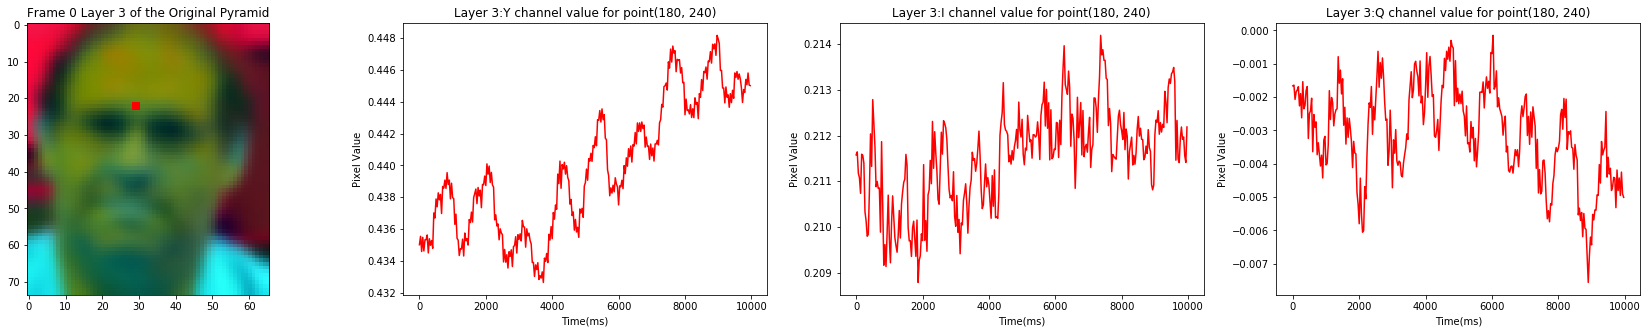

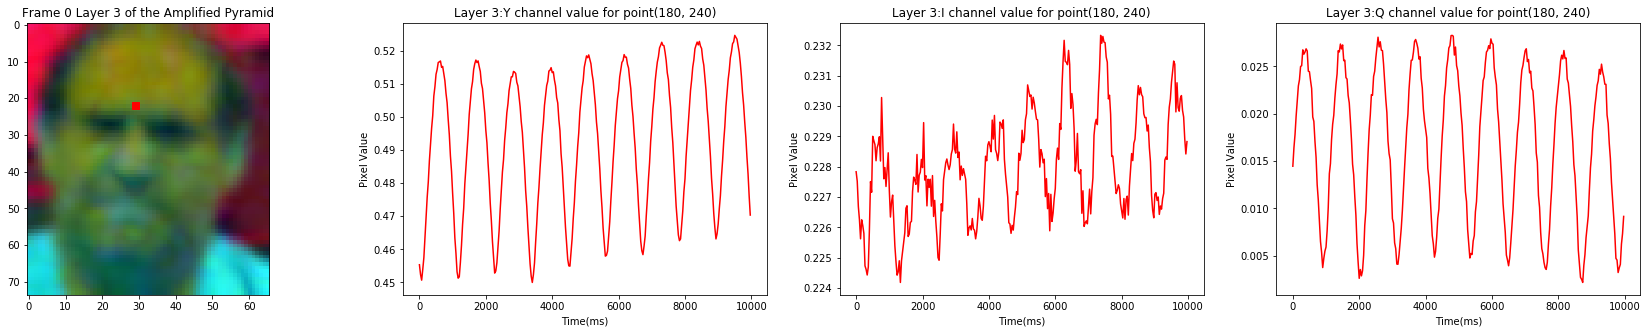

In [20]:
alpha = 100 #The original paper's parameter value 
amplifiedPyr = amplifyTemporalColorSignal(pyrVideo, filteredVideoPyr, alpha, 1)
showTemporalSignal(frames, fps, pyrVideo, maxLevel-1, ypos, xpos, "Original")
showTemporalSignal(frames, fps, amplifiedPyr, maxLevel-1, ypos, xpos, "Amplified")

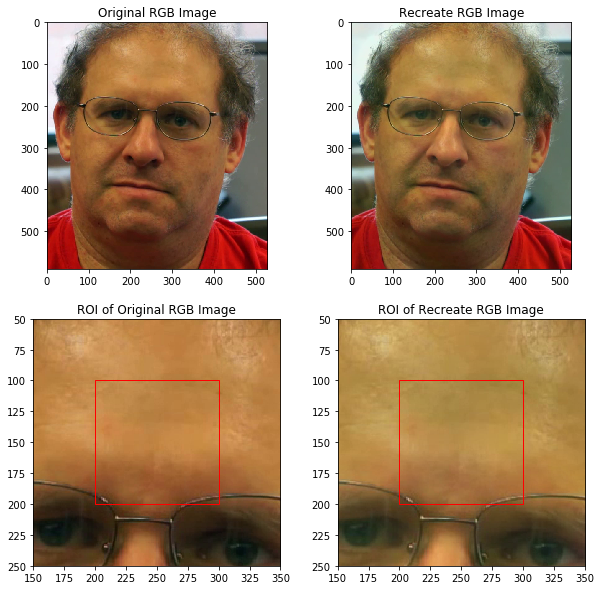

In [21]:
recreateFrames=recreateVideoFromLapPyr(amplifiedPyr)
compareImg(yiq2rgbFloat(frames[20]), yiq2rgbFloat(recreateFrames[20]), roi, "Original RGB Image", "Recreate RGB Image")

In [22]:
def saveFramesToVideo(frames, videoPath):
    """
    Save frames as a video file
    
    Parameters
    ----------
    frames : input video frames
    videoPath: output video file
     
    Note:
    Here I use FOURCC("AVC1") on my macbook pro.
    If needed the FOURCC can be a parameter.
    
    Returns
    -------
    None
    """          
    fourcc = cv2.VideoWriter_fourcc('a','v','c','1')
    [height,width]=frames[0].shape[0:2]
    writer = cv2.VideoWriter(videoPath, fourcc, 30, (width, height), 1)
    for i in range(frames.shape[0]):
        frameBGR = yiq2bgrUint(frames[i])
        writer.write(frameBGR)
    writer.release()
    
def saveFramesToVideoROI(orgFrames, recreateFrames, videoPath, roi=None):
    """
    Save frames as a video file
    
    Parameters
    ----------
    frames : input video frames
    videoPath: output video file
     
    Note:
    Here I use FOURCC("AVC1") on my macbook pro.
    If needed the FOURCC can be a parameter.
    
    Returns
    -------
    None
    """         
    fourcc = cv2.VideoWriter_fourcc('a','v','c','1')
    [height,width]=orgFrames[0].shape[0:2]
    if roi is None:
        top=0
        bottom=height
        left=0
        right=width
    else:
        [top, bottom, left, right] = roi
    writer = cv2.VideoWriter(videoPath, fourcc, 30, (width, height), 1)
    for i in range(recreateFrames.shape[0]):
        recreateFramesBGR = yiq2bgrUint(recreateFrames[i])
        saveFrame = yiq2bgrUint(orgFrames[i])
        saveFrame[top:bottom, left:right] = recreateFramesBGR[top:bottom, left:right]
        writer.write(saveFrame)
    writer.release()    

In [26]:
recreateFrames=recreateVideoFromLapPyr(amplifiedPyr)
saveFramesToVideoROI(frames, recreateFrames, "./assign2/data/myFace2.mp4")

In [28]:
%%HTML
<video width="320" height="240" controls>
  <source src="./assign2/data/myFace2.mp4">
</video>

In [29]:
def emvCoreColor(frames, fps, maxLevel, freqLow, freqHigh, alpha, chromAttenuation, method="ideal"):
    """
    Core function to do Eulerian video magnification, only for color change.
    
    Parameters
    ----------
    frames : input video frames
    fps: frame rate of the input video frames
    maxLevel: upper limit of Laplacian Pyramid
    freqLow, freqHigh: cutoff frequency of bandpass filter
    alpha: amplification rate
    chromAttenuation: attenuation for I/Q channels
    method: "ideal" for ideal IIR bandpass filter
            "butt" for buttworth bandpass filter.
    
    Note:
         Actually buttworth bandpass filter is note suitable for color change application because
         it has too wide frequency response. I leave it here just for experiment and comparison.
    
    Returns
    -------
    Amplified video frames according to [1]
    """       
    pyrVideo_=buildVideoLapPyr(frames, maxLevel)
    
    if method=="ideal":
        filteredVideoPyr=idealFilterForVideoPyr(pyrVideo_, freqLow, freqHigh, fps)
    elif method=="butt":
        filteredVideoPyr=buttFilterForVideoPyr(pyrVideo_, freqLow, freqHigh, fps)
        
    amplifiedPyr = amplifyTemporalColorSignal(pyrVideo_, filteredVideoPyr, alpha, chromAttenuation)
    recreateFrames=recreateVideoFromLapPyr(amplifiedPyr)
    
    return recreateFrames

def emvCoreMotion(frames, fps, maxLevel, freqLow, freqHigh, alpha, lambdaC, chromAttenuation, method="ideal"):
    """
    Core function to do Eulerian video magnification, only for motion change.
    
    Parameters
    ----------
    frames : input video frames
    fps: frame rate of the input video frames
    maxLevel: upper limit of Laplacian Pyramid
    freqLow, freqHigh: cutoff frequency of bandpass filter
    alpha: amplification rate
    lambdaC: lambdaC described in [1]
    chromAttenuation: attenuation for I/Q channels
    method: "ideal" for ideal IIR bandpass filter
            "butt" for buttworth bandpass filter.
    
    Note:
         Actually buttworth bandpass filter is note suitable for color change application because
         it has too wide frequency response. I leave it here just for experiment and comparison.
    
    Returns
    -------
    Amplified video frames according to [1]
    """       
    pyrVideo_=buildVideoLapPyr(frames, maxLevel)
    
    if method=="ideal":
        filteredVideoPyr=idealFilterForVideoPyr(pyrVideo_, freqLow, freqHigh, fps)
    elif method=="butt":
        filteredVideoPyr=buttFilterForVideoPyr(pyrVideo_, freqLow, freqHigh, fps)
        
    amplifiedPyr = amplifyTemporalMotionSignal(pyrVideo_, filteredVideoPyr, alpha, lambdaC, chromAttenuation)
    recreateFrames=recreateVideoFromLapPyr(amplifiedPyr)
    
    return recreateFrames

def emv(inputVideoPath, outputVideoPath, maxLevel, freqLow, freqHigh, alpha, chromAttenuation, startFrameNumber, endFrameNumber, lambdaC=-1, app="color", method="ideal", roi=None):
    """
    Interface function to do Eulerian video magnification
    
    Parameters
    ----------
    inputVideoPath : input video path
    outputVideoPath: output video path
    maxLevel: upper limit of Laplacian Pyramid
    freqLow, freqHigh: cutoff frequency of bandpass filter
    alpha: amplification rate
    chromAttenuation: attenuation for I/Q channels
    startFrameNumber, endFrameNumber: controls the frames we need to process
    
    Returns
    -------
    None. The amplified video is saved to outputVideoPath
    """  
    fps, frames = getVideoFrames(inputVideoPath, startFrameNumber, endFrameNumber)
    if app=="color":
        recreateFrames=emvCoreColor(frames, fps, maxLevel, freqLow, freqHigh, alpha, chromAttenuation, method)
    elif app=="motion":
        recreateFrames=emvCoreMotion(frames, fps, maxLevel, freqLow, freqHigh, alpha, lambdaC, chromAttenuation, method)
    saveFramesToVideoROI(frames, recreateFrames, outputVideoPath, roi)
    return

In [32]:
emv('./assign2/data/baby2.mp4', './assign2/data/myBaby2.mp4', 8, 2.33/2.2, 2.67/2.2, 80, 2, 0, 120, lambdaC=300, app='motion', method='ideal', roi=[80,300,200,500])

In [33]:
%%HTML
<video width="640" height="480" controls>
  <source src="./assign2/data/myBaby2.mp4">
</video>

In [34]:
emv('./assign2/data/face.mp4', './assign2/data/myFaceButt.mp4', 4, 0.83/2, 1.0/2, 30.0, 1, 0, -1, method="butt")

In [35]:
%%HTML
<video width="320" height="240" controls>
  <source src="./assign2/data/myFaceButt.mp4">
</video>